In [1]:
#pip install tensorflow

In [2]:
#pip install matplotlib

In [3]:
#pip install climetlab

In [4]:
#pip install climetlab-eumetnet-postprocessing-benchmark

In [5]:
#pip install --upgrade jupyterlab ipywidgets

In [6]:
#pip install requests

In [7]:
#pip install tensorrt

In [8]:
# trying to do the diagram in temperature

In [39]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib  # For saving scaler model
import os


from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

In [81]:

class ScaledModel:
    def __init__(self, sequence_length, param, feature_count):
        self.sequence_length = sequence_length
        self.param = param
        self.feature_count = feature_count
        self.scaler = MinMaxScaler()
        self.model = self._build_model()
        self.X_test = None  # Initialize X_test
        self.y_test = None  # Initialize y_test

    def _build_model(self):
        model = Sequential([
            ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu',
                       input_shape=(self.sequence_length, 1, 1, self.feature_count), return_sequences=True),
            ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(1)
        ])
        optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def fit(self, df, epochs, batch_size, validation_split=0.2):
        df_scaled = self.scaler.fit_transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        train_idx = int(len(df_scaled) * (1 - validation_split))
        
        train_df = df_scaled.iloc[:train_idx]
        test_df = df_scaled.iloc[train_idx:]
        
        X_train, y_train = self.create_sequences(train_df)
        X_test, y_test = self.create_sequences(test_df)

        self.X_test = X_test.reshape((X_test.shape[0], self.sequence_length, 1, 1, X_train.shape[2]))
        self.y_test = y_test
        
        # Reshape for ConvLSTM
        X_train = X_train.reshape((X_train.shape[0], self.sequence_length, 1, 1, X_train.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], self.sequence_length, 1, 1, X_test.shape[2]))
        
        checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path, save_weights_only=True,
            monitor='val_loss', mode='min', save_best_only=True, verbose=1
        )
        
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                       validation_data=(X_test, y_test), callbacks=[checkpoint])

    def evaluate(self):
        y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_test, y_pred)
        return {"MSE": mse, "RMSE": rmse, "MAE": mae}
        
    def create_sequences(self, input_data, include_target=True):
        X, y = [], []
        for i in range(len(input_data) - self.sequence_length):
            X.append(input_data.iloc[i:(i + self.sequence_length)].values)
            if include_target:
                y.append(input_data.iloc[i + self.sequence_length][self.param])
        if include_target:
            return np.array(X), np.array(y)
        else:
            return np.array(X)  # Return only X if include_target is False


    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        self.model.save(os.path.join(path, 'model.keras'))
        joblib.dump(self.scaler, os.path.join(path, 'scaler.pkl'))

    def load_model_and_scaler(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'model.keras'))
        self.scaler = joblib.load(os.path.join(path, 'scaler.pkl'))

    
    def predict(self, df):
        df_scaled = self.scaler.transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        X = self.create_sequences(df_scaled, include_target=False)
        X = X.reshape((X.shape[0], self.sequence_length, 1, 1, X.shape[2]))
        prediction_scaled = self.model.predict(X)
        dummy_output_array = np.zeros((prediction_scaled.shape[0], self.scaler.n_features_in_))
        dummy_output_array[:, 3] = prediction_scaled.squeeze()
        return self.scaler.inverse_transform(dummy_output_array)[:, 3]

        
    def predict_future(self, df, steps=6):
        # Transform the DataFrame and prepare for feature manipulation
        df_scaled = self.scaler.transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        
        predictions = []
        for _ in range(steps):
            # Use the last available sequence_length of data
            future_data = df_scaled.tail(self.sequence_length).values.reshape(1, self.sequence_length, 1, 1, self.feature_count)
            
            # Predict the next T2M value
            next_t2m_prediction = self.model.predict(future_data).flatten()[0]
            
            # Scale back the predicted T2M value
            dummy_output_array = np.zeros((1, self.scaler.n_features_in_))
            dummy_output_array[:, 3] = next_t2m_prediction  # Assuming T2M is at index 3
            predicted_t2m_scaled_back = self.scaler.inverse_transform(dummy_output_array)[0, 3]
            
            predictions.append(predicted_t2m_scaled_back)
            
            # Prepare for the next prediction by updating features
            new_row = df_scaled.iloc[-1].copy()
            new_row['T2M'] = next_t2m_prediction  # Update T2M with the new prediction
            
            # Assume time progression of one hour for cyclic and rolling features
            new_row['hour_sin'] = np.sin(2 * np.pi * ((new_row['hour'] + 1) % 24) / 24)
            new_row['hour_cos'] = np.cos(2 * np.pi * ((new_row['hour'] + 1) % 24) / 24)
            new_row['day_sin'] = np.sin(2 * np.pi * ((new_row['day_of_year'] + 1) % 365) / 365)
            new_row['day_cos'] = np.cos(2 * np.pi * ((new_row['day_of_year'] + 1) % 365) / 365)
            
            # Update rolling statistics assuming you can calculate them on the fly
            if 'T2M_rolling_mean_24h' in new_row:
                # Simple approximation for rolling stats by using the mean of existing values and the new prediction
                new_row['T2M_rolling_mean_24h'] = df_scaled['T2M'].tail(23).append(pd.Series(next_t2m_prediction)).mean()
                new_row['T2M_rolling_max_24h'] = df_scaled['T2M'].tail(23).append(pd.Series(next_t2m_prediction)).max()
                new_row['T2M_rolling_min_24h'] = df_scaled['T2M'].tail(23).append(pd.Series(next_t2m_prediction)).min()
                new_row['T2M_rolling_std_24h'] = df_scaled['T2M'].tail(23).append(pd.Series(next_t2m_prediction)).std()
    
            # Append the new row to df_scaled
            df_scaled = pd.concat([df_scaled, pd.DataFrame([new_row])], ignore_index=True)
    
        return predictions



    def plot_predictions(self, y_test, y_pred):
        plt.figure(figsize=(15, 6))
        
        # Line plot of the actual vs predicted
        plt.subplot(1, 2, 1)
        plt.plot(y_test, label='Actual', linestyle='-')
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.title('Detailed View of Predictions vs. Actual')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        
        # Scatter plot of the actual vs predicted
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.title('Prediction vs Actual')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line
        
        plt.tight_layout()
        plt.show()

    def evaluate_and_plot(self):
        y_pred = self.model.predict(self.X_test).flatten()
        y_test = self.y_test.flatten()  # Ensure y_test is flat if it's not already
        dummy_array = np.zeros((y_pred.shape[0], self.feature_count))
        dummy_array[:, 3] = y_pred.squeeze() 
        test_dummy_array = np.zeros((y_test.shape[0], self.feature_count))
        test_dummy_array[:, 3] = y_test.squeeze()  
        test_y = self.scaler.inverse_transform(test_dummy_array)[:, 3]
        predictions_y = self.scaler.inverse_transform(dummy_array)[:, 3]

        metrics = self.evaluate()  # Calling evaluate to use existing evaluation metrics
        print("Mean Squared Error:", metrics['MSE'])
        print("Root Mean Squared Error:", metrics['RMSE'])
        print("Mean Absolute Error:", metrics['MAE'])
        self.plot_predictions(test_y, predictions_y)




In [57]:

def fetch_data(start_date = '2018-01-01', end_date='2024-01-01'):
    url_template = ("https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?"
                    "parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&"
                    "parameters=RH2M&parameters=UU&parameters=VV&start={start_date}T00%3A00&"
                    "end={end_date}T00%3A00&lat_lon=48.333056%2C16.631944&"
                    "lat_lon=48.115278%2C16.175833&output_format=geojson&"
                    "filename=INCA_Vienna_timeseries_all_parameters_{start_year}_{end_year}_0101")
    formatted_url = url_template.format(start_date=start_date, end_date=end_date, 
                                        start_year=start_date[:4], end_year=end_date[:4])
    print(formatted_url)
    response = requests.get(formatted_url)
    if response.status_code == 200:
        data = response.json()
        print("Fetched data successfully")
    else:
        print("Failed to retrieve data", response.status_code)

    # Processing the data
    data_list = []
    for feature in data['features']:
        location = feature['geometry']['coordinates']
        for i, timestamp in enumerate(data['timestamps']):
            record = {
                'time': pd.to_datetime(timestamp),
                'longitude': location[0],
                'latitude': location[1],
                'RR': feature['properties']['parameters']['RR']['data'][i],
                'T2M': feature['properties']['parameters']['T2M']['data'][i],
                'RH2M': feature['properties']['parameters']['RH2M']['data'][i],
                'TD2M': feature['properties']['parameters']['TD2M']['data'][i],
                'GL': feature['properties']['parameters']['GL']['data'][i],
                'UU': feature['properties']['parameters']['UU']['data'][i],
                'VV': feature['properties']['parameters']['VV']['data'][i],
                'P0': feature['properties']['parameters']['P0']['data'][i]
            }
            data_list.append(record)

    original_df = pd.DataFrame(data_list)
    return original_df


In [82]:
def calculate_rolling_features(df, window_size, feature_name):
    if len(df) < window_size:
        window_size = len(df)  # Adjust window size to length of the data if data is too short
    df[f'{feature_name}_rolling_mean'] = df['T2M'].rolling(window=window_size).mean()
    df[f'{feature_name}_rolling_max'] = df['T2M'].rolling(window=window_size).max()
    df[f'{feature_name}_rolling_min'] = df['T2M'].rolling(window=window_size).min()
    df[f'{feature_name}_rolling_std'] = df['T2M'].rolling(window=window_size).std()

def calculate_ewm_features(df, span, feature_name):
    df[f'{feature_name}_ewm'] = df['T2M'].ewm(span=span, adjust=False).mean()

def handle_na(df):
    df.fillna(method='ffill', inplace=True)  # Forward fill first to propagate last valid observation forward
    df.fillna(method='bfill', inplace=True)  # Backward fill to ensure no NaNs remain

def feature_engineering(df):
    df.dropna(inplace=True)  # Drop rows with NaN values first

    # Basic date-time features
    df['hour'] = df['time'].dt.hour
    df['day_of_year'] = df['time'].dt.dayofyear
    df['week_of_year'] = df['time'].dt.isocalendar().week
    df['day_of_month'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year

    # Wind and interaction features
    df['wind_speed'] = np.sqrt(df['UU']**2 + df['VV']**2)
    df['wind_direction'] = np.arctan2(df['VV'], df['UU']) * 180 / np.pi
    df['temp_humidity_interaction'] = df['T2M'] * df['RH2M']
    df['wind_rain_interaction'] = df['wind_speed'] * df['RR']
    df['RR_lag1'] = df['RR'].shift(1)
    df['T2M_lag1'] = df['T2M'].shift(1)

    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year']/365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year']/365)

    # Rolling and EWMA features
    calculate_rolling_features(df, 24, '24h')  # 24-hour window
    calculate_rolling_features(df, 24*7, '7d')  # 7-day window
    calculate_ewm_features(df, 24, '24h')  # EWMA for 24 hours
    calculate_ewm_features(df, 24*7, '7d')  # EWMA for 7 days

    # Handle NaNs intelligently
    handle_na(df)

    # Ensure only numeric types are used for modeling
    df = df.select_dtypes(include=[np.number])
    
    return df


In [83]:
def get_data_for_convlstm(start_date, end_date):
    df = feature_engineering(fetch_data(start_date, end_date).copy()).copy()
    return df

In [84]:
preprocessed_df = fetch_data().copy()

https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2018-01-01T00%3A00&end=2024-01-01T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2018_2024_0101
Fetched data successfully


In [85]:
preprocessed_df_copy = preprocessed_df.copy()

In [86]:
feature_df  = feature_engineering(preprocessed_df).copy()

/tmp/ipykernel_128490/630507729.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill first to propagate last valid observation forward
/tmp/ipykernel_128490/630507729.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill to ensure no NaNs remain


In [87]:
feature_df_copy = feature_df.copy

In [88]:
df = feature_df.copy()
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,24h_rolling_mean,24h_rolling_max,24h_rolling_min,24h_rolling_std,7d_rolling_mean,7d_rolling_max,7d_rolling_min,7d_rolling_std,24h_ewm,7d_ewm
0,16.638773,48.334339,0.000,1.68,94.58,0.91,0.0,-1.08,1.06,101026.92,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.680000,1.680000
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.639200,1.673964
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.540064,1.658888
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.457659,1.645292
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.380246,1.631620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,...,1.450000,3.45,-0.91,1.274571,6.981190,14.18,-0.91,3.909641,2.314958,5.679273
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,...,1.420417,3.45,-0.91,1.239458,6.933988,14.18,-0.91,3.915498,2.330561,5.641766
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,...,1.353333,3.12,-0.91,1.166241,6.878810,14.18,-0.91,3.921609,2.291316,5.596775
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,...,1.409583,4.47,-0.91,1.281970,6.835119,14.18,-0.91,3.907203,2.465611,5.583441


In [89]:
param = 'T2M'
sequence_length = 24
feature_count = df.shape[1]
print("Number of features:", feature_count)


Number of features: 38


In [90]:
scaled_model = ScaledModel(sequence_length=sequence_length, param=param, feature_count=feature_count)
scaled_model.fit(df, epochs=3, batch_size=32)

# To save model and scaler
scaled_model.save('saved_model_scaler')

/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3


2024-04-28 14:23:25.889114: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 306665472 exceeds 10% of free system memory.


2626/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061
Epoch 1: val_loss improved from inf to 0.00052, saving model to checkpoints/model_epoch_01_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - loss: 0.0061 - val_loss: 5.1551e-04
Epoch 2/3
2625/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7042e-04
Epoch 2: val_loss improved from 0.00052 to 0.00019, saving model to checkpoints/model_epoch_02_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - loss: 2.7040e-04 - val_loss: 1.8711e-04
Epoch 3/3
2626/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0828e-04
Epoch 3: val_loss did not improve from 0.00019
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - loss: 2.0828e-04 - val_loss: 1.9953e-04


In [91]:
# To load model and scaler
scaled_model.load_model_and_scaler('saved_model_scaler')

657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Mean Squared Error: 0.0001995288633228562
Root Mean Squared Error: 0.014125468605425314
Mean Absolute Error: 0.009413823922342168
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Mean Squared Error: 0.0001995288633228562
Root Mean Squared Error: 0.014125468605425314
Mean Absolute Error: 0.009413823922342168


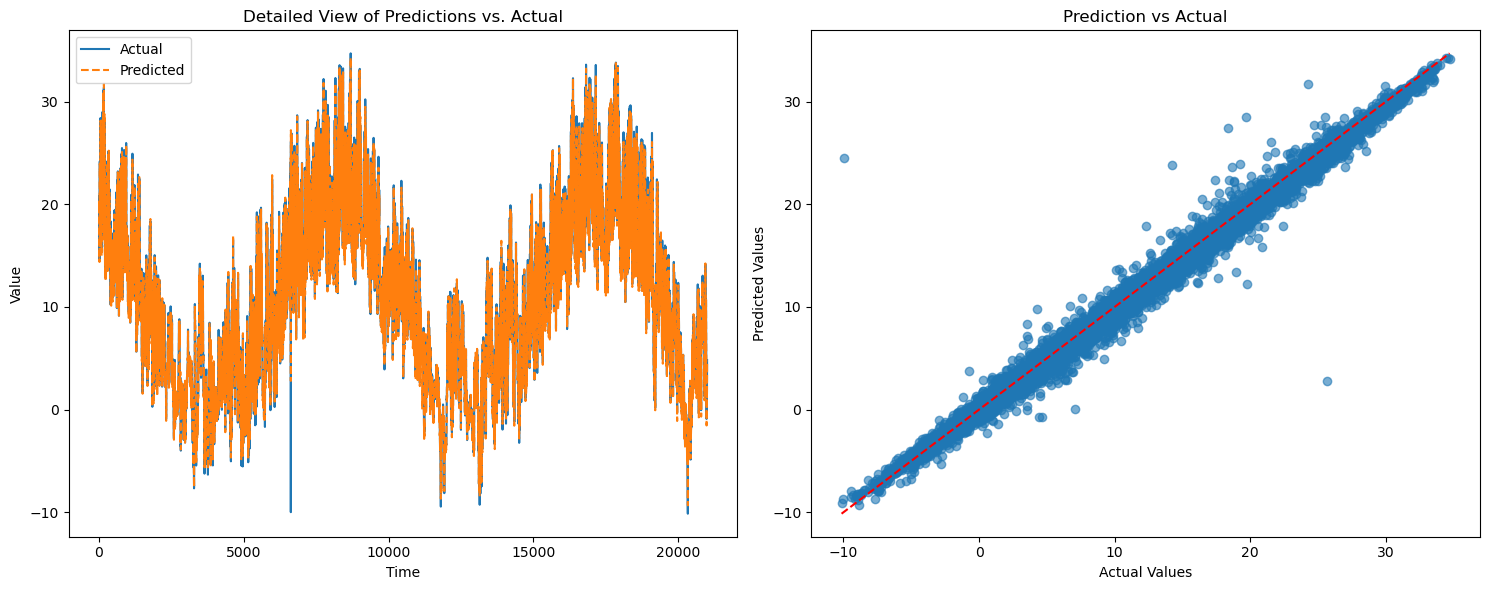

In [92]:
metrics = scaled_model.evaluate()
print("Mean Squared Error:", metrics['MSE'])
print("Root Mean Squared Error:", metrics['RMSE'])
print("Mean Absolute Error:", metrics['MAE'])
scaled_model.evaluate_and_plot()

In [109]:
data_for_prediction = get_data_for_convlstm('2023-06-22', '2023-06-23')


https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2023-06-22T00%3A00&end=2023-06-23T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2023_2023_0101
Fetched data successfully


/tmp/ipykernel_128490/630507729.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill first to propagate last valid observation forward
/tmp/ipykernel_128490/630507729.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill to ensure no NaNs remain


In [110]:
print("Total rows in data_for_prediction:", len(data_for_prediction))
print("Total rows in df:", len(df))


Total rows in data_for_prediction: 50
Total rows in df: 105110


In [111]:
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,24h_rolling_mean,24h_rolling_max,24h_rolling_min,24h_rolling_std,7d_rolling_mean,7d_rolling_max,7d_rolling_min,7d_rolling_std,24h_ewm,7d_ewm
0,16.638773,48.334339,0.000,1.68,94.58,0.91,0.0,-1.08,1.06,101026.92,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.680000,1.680000
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.639200,1.673964
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.540064,1.658888
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.457659,1.645292
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.380246,1.631620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,...,1.450000,3.45,-0.91,1.274571,6.981190,14.18,-0.91,3.909641,2.314958,5.679273
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,...,1.420417,3.45,-0.91,1.239458,6.933988,14.18,-0.91,3.915498,2.330561,5.641766
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,...,1.353333,3.12,-0.91,1.166241,6.878810,14.18,-0.91,3.921609,2.291316,5.596775
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,...,1.409583,4.47,-0.91,1.281970,6.835119,14.18,-0.91,3.907203,2.465611,5.583441


In [112]:
predictions = scaled_model.predict_future(data_for_prediction.copy().iloc[-48:], steps=24)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[23.298254534602172, 23.412202072739607, 23.600298631787307, 23.66304106891156, 23.76015

In [113]:
print("First timestamp:", data_for_prediction.index.min())
print("Last timestamp:", data_for_prediction.index.max())
print("Unique timestamps count:", data_for_prediction.index.nunique())


First timestamp: 0
Last timestamp: 49
Unique timestamps count: 50


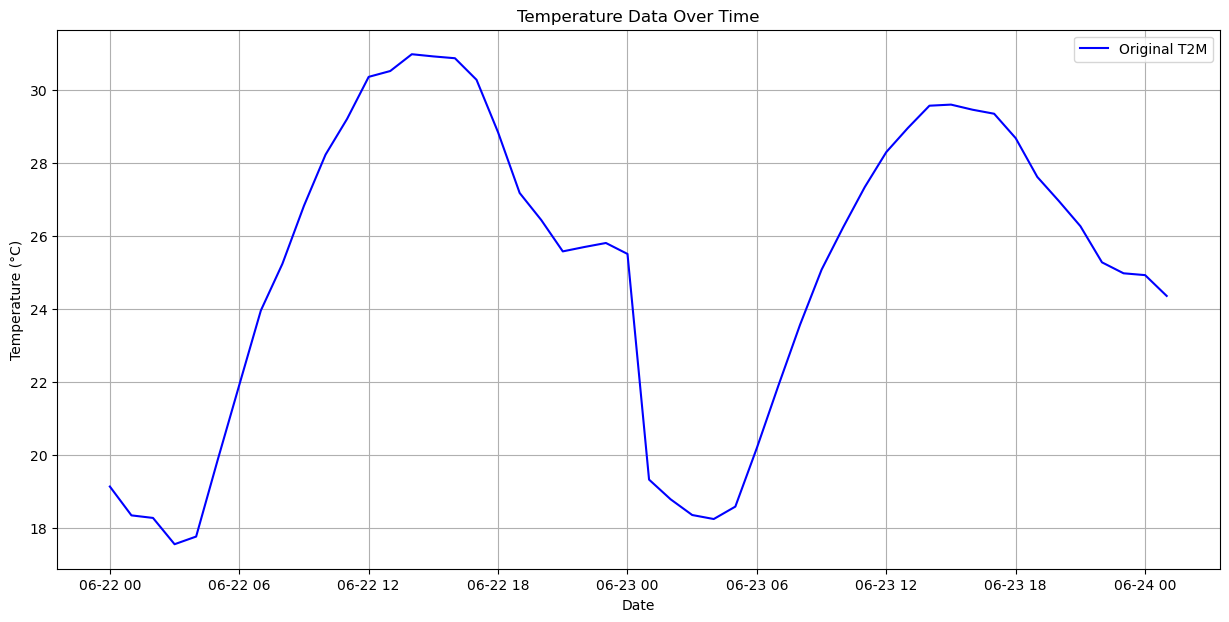

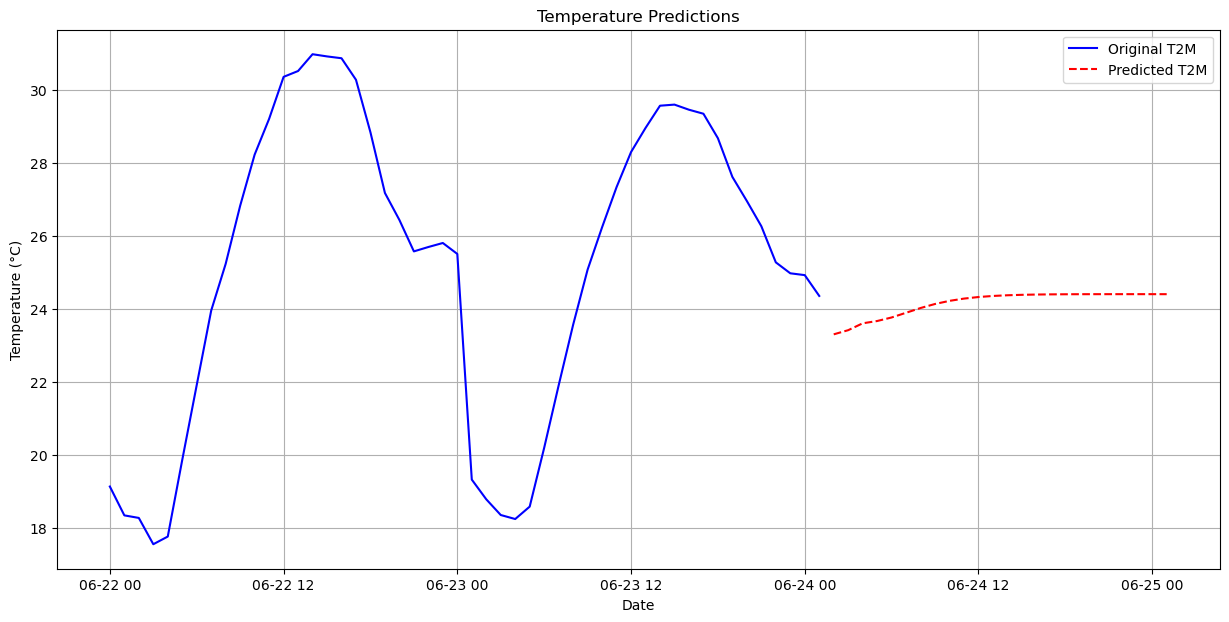

In [114]:
start_datetime = '2023-06-22 00:00:00'

# Generate a datetime index starting from `start_datetime`
new_index = pd.date_range(start=start_datetime, periods=data_for_prediction.index.nunique(), freq='H')  # 'H' for hourly

# Assign this new index to your DataFrame
data_for_prediction.index = new_index

# Now plot as before
plt.figure(figsize=(15, 7))
plt.plot(data_for_prediction.index, data_for_prediction['T2M'], label='Original T2M', color='blue')
plt.title('Temperature Data Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

last_timestamp = data_for_prediction.index[-1]
prediction_frequency = 'H'  # 'H' for hourly

# Generate new timestamps for predictions
new_timestamps = pd.date_range(start=last_timestamp, periods=len(predictions) + 1, freq=prediction_frequency)[1:]

# Continue as previously to plot predictions alongside original data
predictions_df = pd.DataFrame(predictions, index=new_timestamps, columns=['Predicted T2M'])
combined_df = pd.concat([data_for_prediction, predictions_df])

plt.figure(figsize=(15, 7))
plt.plot(combined_df.index, combined_df['T2M'], label='Original T2M', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted T2M'], label='Predicted T2M', color='red', linestyle='--')
plt.title('Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()



In [19]:
        # Optionally, you can plot the predictions - Adjust plotting to handle scaled values if needed
        plt.figure(figsize=(10, 5))
        actual_scaled = self.scaler.inverse_transform(df_scaled)[:, 3]  # Assuming index 3 is the feature being predicted
        plt.plot(range(len(actual_scaled)), actual_scaled, label='Original data')
        plt.plot(range(len(actual_scaled), len(actual_scaled) + steps), predictions, label='Predicted data')
        plt.legend()
        plt.show()
    

NameError: name 'self' is not defined

<Figure size 1000x500 with 0 Axes>

In [20]:
data_for_prediction = get_data_for_convlstm('2024-02-02', '2024-02-03')
print("Scaler min values:", scaled_model.scaler.min_)
print("Scaler scale values:", scaled_model.scaler.scale_)
def scale_temperature(T, min_temp=-10, scale=45):
    return (T - min_temp) / scale

# Test the scaling
scaled_minus_10 = scale_temperature(-10)  # Expected to be 0
scaled_35 = scale_temperature(35)         # Expected to be 1
scaled_20 = scale_temperature(20)         # Expected to be 1
scaled_5 = scale_temperature(-5)         # Expected to be 1

scaled_minus_10, scaled_35, scaled_20, scaled_5


https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-02-02T00%3A00&end=2024-02-03T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2024_2024_0101
Fetched data successfully
Scaler min values: [-3.53499231e+01 -2.16755805e+02  0.00000000e+00  3.04614206e-01
 -1.45475372e-01  4.40229598e-01  0.00000000e+00  4.34725849e-01
  5.07621951e-01 -1.56912065e+01  0.00000000e+00 -1.92307692e-02
 -9.09090909e-02  0.00000000e+00  4.99844830e-01  3.98302190e-01
  0.00000000e+00  0.00000000e+00  3.04614206e-01  5.00000000e-01
  5.00000000e-01 -2.73972603e-03  5.00000000e-01  4.99990740e-01
  3.04532032e-01]
Scaler scale values: [2.18465167e+00 4.50519876e+00 2.00224251e-02 1.91460846e-02
 1.14547537e-02 2.49563264e-02 9.83448561e-04 4.35161010e-02
 5.08130081e-02 1.

(0.0, 1.0, 0.6666666666666666, 0.1111111111111111)

In [21]:
predictions = scaled_model.predict_future(data_for_prediction.copy().iloc[-48:], steps=24)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[8.641888642013077, 8.091706206798559, 7.745983050167565, 7.56692396730185, 7.4777228632

In [33]:
predic = scaled_model.predict(data_for_prediction.copy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


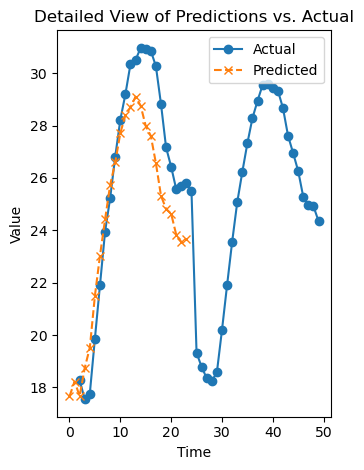

In [36]:
plt.subplot(1, 2, 1)
plt.plot(data_for_prediction['T2M'], label='Actual', marker='o', linestyle='-')
plt.plot(predic, label='Predicted', marker='x', linestyle='--')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Scatter plot of the actual vs predicted
plt.tight_layout()
plt.show()

In [24]:
predictions = scaled_model.predict_future(data_for_prediction.copy().iloc[-48:], steps=24)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [25]:
predictions = scaled_model.predict_future(feature_df.copy().iloc[-24:], steps=6)
print("Predictions for the next 6 time points:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions for the next 6 time points: [4.805448871254925, 5.434960609972482, 5.207949668467049, 4.659613331556325, 4.152384591698651, 3.835319542884831]


In [11]:
df = original_df.copy()

In [12]:
df.dropna(inplace=True)  # Drop rows with NaN values first

# Feature engineering and selection
df['hour'] = df['time'].dt.hour
df['week_of_year'] = df['time'].dt.isocalendar().week
df['month'] = df['time'].dt.month

df['wind_speed'] = np.sqrt(df['UU']**2 + df['VV']**2)
df['wind_direction'] = np.arctan2(df['VV'], df['UU']) * 180 / np.pi

df['temp_humidity_interaction'] = df['T2M'] * df['RH2M']
df['wind_rain_interaction'] = df['wind_speed'] * df['RR']

df['RR_lag1'] = df['RR'].shift(1)
df['T2M_lag1'] = df['T2M'].shift(1)

df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])

all_columns_df  = df.copy()

df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,hour,week_of_year,month,wind_speed,wind_direction,temp_humidity_interaction,wind_rain_interaction,RR_lag1,T2M_lag1
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,1,1,1,2.237878,159.054397,112.5891,0.00000,0.0,1.68
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,2,1,1,0.396232,47.045408,39.7680,0.00000,0.0,1.17
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,3,1,1,0.645136,18.996654,51.0000,0.00000,0.0,0.40
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,4,1,1,0.873212,29.500725,49.0000,0.00000,0.0,0.51
5,16.638773,48.334339,0.000,0.60,100.00,0.60,0.0,0.43,-0.55,100951.46,5,1,1,0.698140,-51.981057,60.0000,0.00000,0.0,0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,20,52,12,0.268701,45.000000,194.7894,0.00000,0.0,1.52
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,21,52,12,1.185960,24.403972,208.1041,0.00000,0.0,2.26
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,22,52,12,0.262488,40.364537,155.2408,0.00000,0.0,2.51
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,23,52,12,4.358497,22.387285,350.9397,0.00000,0.0,1.84


In [13]:
# Sequence creation for LSTM
def create_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data.iloc[i:(i + sequence_length)].values)
        y.append(input_data.iloc[i + sequence_length]['T2M'])
    return np.array(X), np.array(y)

In [14]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

# Train test split
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

sequence_length = 24
X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)

# Reshape data for ConvLSTM
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_test.shape[2]))

# Model creation
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', input_shape=(sequence_length, 1, 1, X_train.shape[-1]), return_sequences=True),
    ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

2024-04-27 12:28:11.761869: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-27 12:28:11.762051: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: babylap
2024-04-27 12:28:11.762064: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: babylap
2024-04-27 12:28:11.762213: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.171.4
2024-04-27 12:28:11.762245: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.171.4
2024-04-27 12:28:11.762254: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.171.4
/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 24, 1, 1, 64)   │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 1, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,621 (139.14 KB)

 Trainable params: 35,621 (139.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Define the checkpoint path and filename
checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Set to False if you want to save the entire model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # The lower the val_loss, the better
    save_best_only=True,  # Only save a model if `val_loss` has improved
    verbose=1  # Log message when saving the model
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15, 
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

Epoch 1/15


2024-04-27 12:28:12.765775: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153330912 exceeds 10% of free system memory.


2625/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0069
Epoch 1: val_loss improved from inf to 0.00023, saving model to checkpoints/model_epoch_01_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 64s 23ms/step - loss: 0.0069 - val_loss: 2.3109e-04
Epoch 2/15
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.5279e-04
Epoch 2: val_loss improved from 0.00023 to 0.00022, saving model to checkpoints/model_epoch_02_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step - loss: 2.5278e-04 - val_loss: 2.2144e-04
Epoch 3/15
2625/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.1126e-04
Epoch 3: val_loss improved from 0.00022 to 0.00017, saving model to checkpoints/model_epoch_03_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - loss: 2.1125e-04 - val_loss: 1.7228e-04
Epoch 4/15
2626/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7400e-04
Epoch 4: val_loss did not improve from 0.00017
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - loss: 1.7400

In [17]:
# Save the entire model to a HDF5 file
model_name = "final_model{date:%Y%m%dT%H%M%S}.keras".format(date=datetime.now())
model.save(model_name)

# Load the model back
from tensorflow.keras.models import load_model
loaded_model = load_model(model_name)

/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [18]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Mean Squared Error: 0.00017436567256221878
Root Mean Squared Error: 0.013204759466276498
Mean Absolute Error: 0.008784666715057239


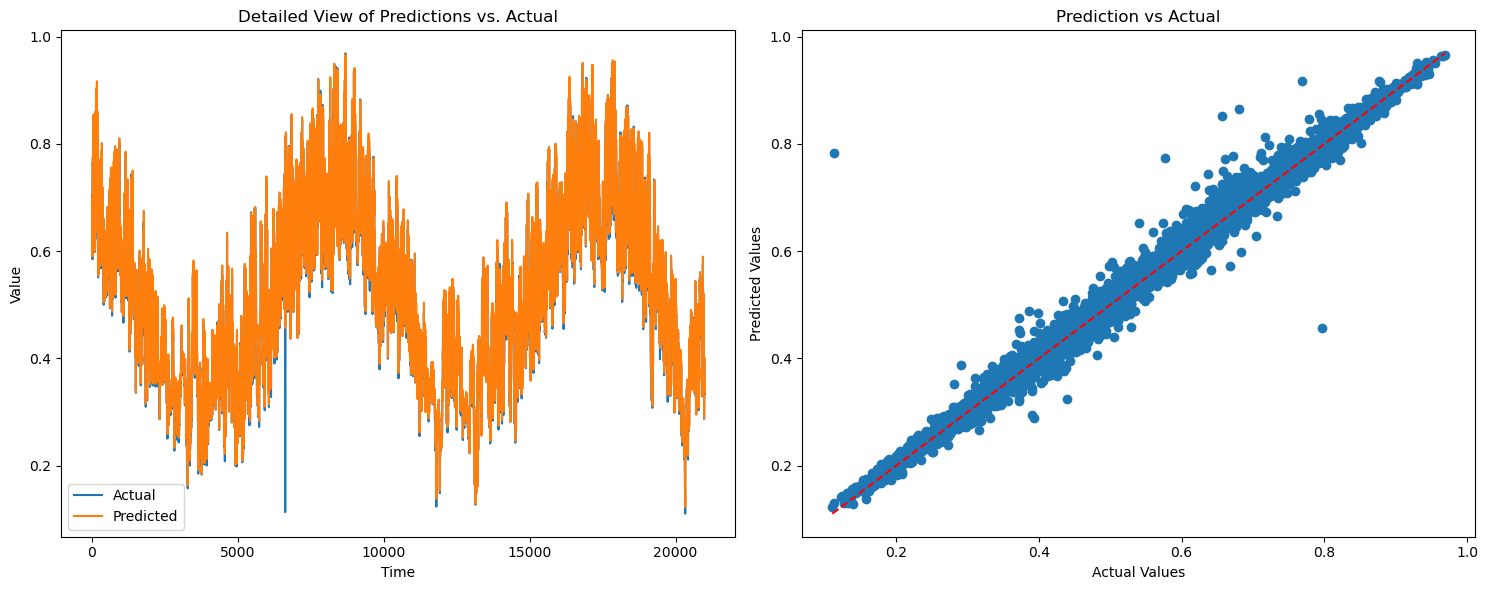

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line

plt.tight_layout()
plt.show()


In [20]:
y_test


array([0.68715298, 0.68945051, 0.69002489, ..., 0.339843  , 0.3901972 ,
       0.39689833])

In [21]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

dummy_array = np.zeros((y_pred.shape[0], feature_count))

# Assume your model's prediction corresponds to the first feature scaled
dummy_array[:, 3] = y_pred.squeeze()  # Make sure this aligns with how your features were scaled

test_dummy_array = np.zeros((y_test.shape[0], feature_count))

# Assume your model's prediction corresponds to the first feature scaled
test_dummy_array[:, 3] = y_test.squeeze()  # Make sure this aligns with how your features were scaled

# Now you can perform the inverse transformation on the correctly shaped data
test_y = scaler.inverse_transform(test_dummy_array)[:, 3]

# If you need the output as a single feature column
# Inverse transform and then extract the relevant feature(s)
predictions_y = scaler.inverse_transform(dummy_array)[:, 3]

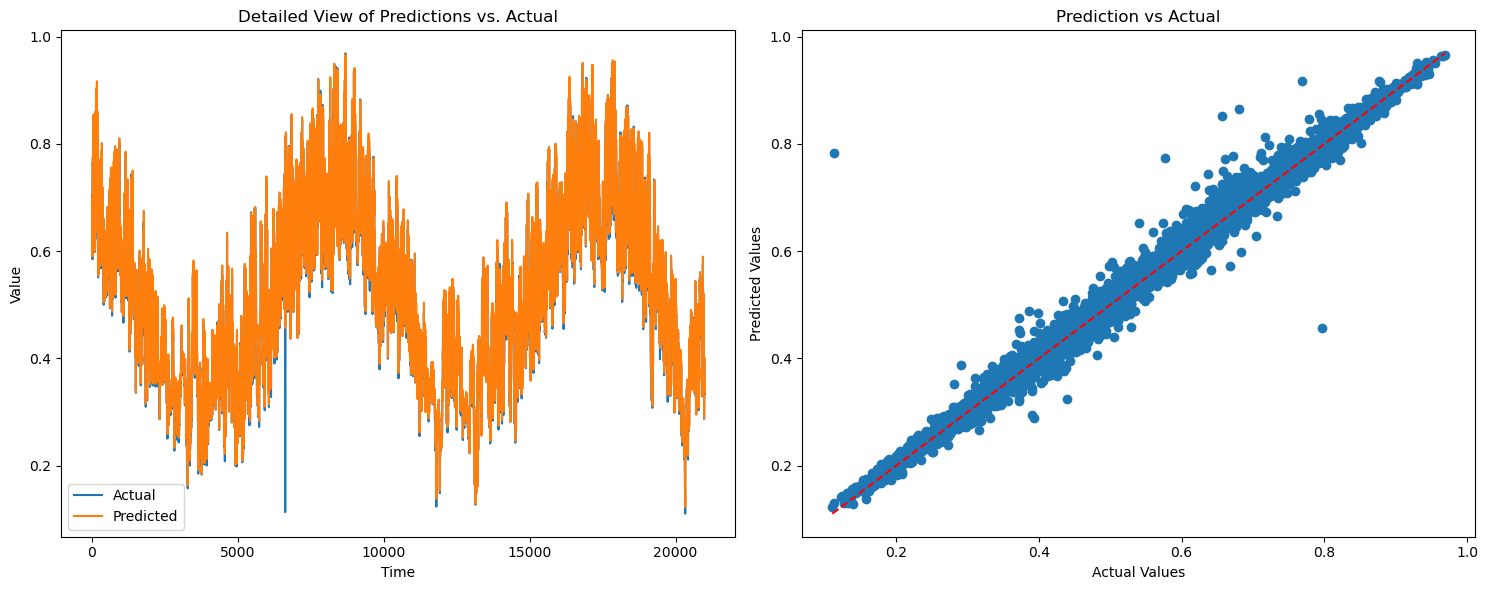

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(test_y, label='Actual')
plt.plot(predictions_y, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(test_y, predictions_y)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line

plt.tight_layout()
plt.show()


In [23]:

# URL for data retrieval
latest_url = "https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-01-01T00%3A00&end=2024-01-02T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2018_2023_0101"
response = requests.get(latest_url)
if response.status_code == 200:
    data = response.json()
    print("Fetched data successfully")
else:
    print("Failed to retrieve data", response.status_code)

# Data processing
latest_data_list = []
for feature in data['features']:
    location = feature['geometry']['coordinates']
    for i, timestamp in enumerate(data['timestamps']):
        record = {
            'time': pd.to_datetime(timestamp),
            'longitude': location[0],
            'latitude': location[1],
            'RR': feature['properties']['parameters']['RR']['data'][i],
            'T2M': feature['properties']['parameters']['T2M']['data'][i],
            'RH2M': feature['properties']['parameters']['RH2M']['data'][i],
            'TD2M': feature['properties']['parameters']['TD2M']['data'][i],
            'GL': feature['properties']['parameters']['GL']['data'][i],
            'UU': feature['properties']['parameters']['UU']['data'][i],
            'VV': feature['properties']['parameters']['VV']['data'][i],
            'P0': feature['properties']['parameters']['P0']['data'][i]
        }
        latest_data_list.append(record)

# Create DataFrame
latest_data = pd.DataFrame(latest_data_list)
latest_data

Fetched data successfully


,time,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0
0,2024-01-01 00:00:00+00:00,16.638773,48.334339,0.000,3.11,95.14,2.41,0.00,1.81,-1.84,101023.61
1,2024-01-01 01:00:00+00:00,16.638773,48.334339,0.000,3.95,89.14,2.33,0.00,2.76,-1.23,101008.01
2,2024-01-01 02:00:00+00:00,16.638773,48.334339,0.169,4.09,91.64,2.86,0.00,4.38,-0.62,101061.41
3,2024-01-01 03:00:00+00:00,16.638773,48.334339,1.540,3.65,93.97,2.77,0.00,4.73,-1.19,101084.14
4,2024-01-01 04:00:00+00:00,16.638773,48.334339,0.892,3.54,96.05,2.97,0.00,3.79,-1.15,101047.74
5,2024-01-01 05:00:00+00:00,16.638773,48.334339,0.071,3.42,96.77,2.95,0.00,3.26,-0.60,101030.58
6,2024-01-01 06:00:00+00:00,16.638773,48.334339,0.127,3.49,97.94,3.20,0.00,2.66,-1.30,101076.60
7,2024-01-01 07:00:00+00:00,16.638773,48.334339,0.189,3.75,97.39,3.38,0.00,3.00,-0.72,101135.91
8,2024-01-01 08:00:00+00:00,16.638773,48.334339,0.092,4.22,94.87,3.47,23.53,2.81,-0.39,101141.54
9,2024-01-01 09:00:00+00:00,16.638773,48.334339,0.000,4.90,92.88,3.85,73.21,2.40,-0.55,101156.25


In [24]:
latest_df = latest_data.copy()

In [25]:
latest_df.dropna(inplace=True)  # Drop rows with NaN values first

# Feature engineering and selection
latest_df['hour'] = latest_df['time'].dt.hour
latest_df['week_of_year'] = latest_df['time'].dt.isocalendar().week
latest_df['month'] = latest_df['time'].dt.month

latest_df['wind_speed'] = np.sqrt(latest_df['UU']**2 + latest_df['VV']**2)
latest_df['wind_direction'] = np.arctan2(latest_df['VV'], latest_df['UU']) * 180 / np.pi

latest_df['temp_humidity_interaction'] = latest_df['T2M'] * latest_df['RH2M']
latest_df['wind_rain_interaction'] = latest_df['wind_speed'] * latest_df['RR']

latest_df['RR_lag1'] = latest_df['RR'].shift(1)
latest_df['T2M_lag1'] = latest_df['T2M'].shift(1)

latest_df.dropna(inplace=True)
latest_df = latest_df.select_dtypes(include=[np.number])
latest_df_copy = latest_df.copy()

scaler = MinMaxScaler()
latest_df_scaled = scaler.fit_transform(latest_df)
latest_df = pd.DataFrame(latest_df_scaled, columns=latest_df.columns)


In [26]:

new_X, _ = create_sequences(latest_df, sequence_length)
new_X = new_X.reshape((new_X.shape[0], sequence_length, 1, 1, new_X.shape[2]))

# Predict using the model
new_predictions = model.predict(new_X)

# If scaling was used during training, invert the scaling on predictions
# Ensure 'scaler' used here was fit on the training data
#new_predictions = scaler.inverse_transform(new_predictions.reshape(-1, 1)).reshape(-1)  # Adjust as necessary based on your scaler

# Output processing as needed, for example:

actual_predictions = latest_df_copy.copy()

#actual_predictions['time'] = actual_predictions['time'].dt.hour

# Rename the columns as specified

# Create a new DataFrame with only the desired columns
actual_predictions = actual_predictions[['T2M']]

#new_X_reshaped = new_X.reshape(-1, 1)  # Adjust this based on your specific situation

# Now you can perform the inverse transformation
#new_X_inversed = scaler.inverse_transform(new_X_reshaped)

# Create a dummy array with the shape [n_samples, n_features] where n_features is how many were scaled originally
dummy_array = np.zeros((new_predictions.shape[0], feature_count))

# Assume your model's prediction corresponds to the first feature scaled
dummy_array[:, 3] = new_predictions.squeeze()  # Make sure this aligns with how your features were scaled

# Now you can perform the inverse transformation on the correctly shaped data
new_X_inversed = scaler.inverse_transform(dummy_array)[:, 3]

# If you need the output as a single feature column
# Inverse transform and then extract the relevant feature(s)
original_scale_predictions = scaler.inverse_transform(dummy_array)[:, 3]  # Select only the predicted feature column


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


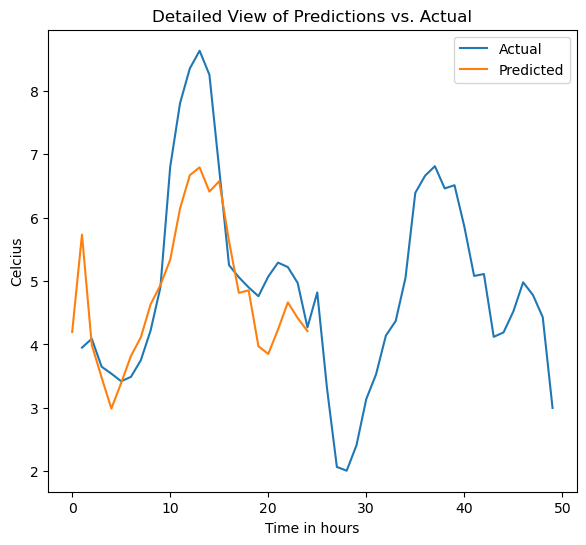

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(actual_predictions, label='Actual')
plt.plot(original_scale_predictions, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time in hours')
plt.ylabel('Celcius')
plt.legend()


plt.show()

In [35]:
x_input = y_test[-1]  # last known data point
print("Shape of x_input before reshaping:", x_input.shape)

# Ensure the reshape parameters are correct
# For example, if x_input is supposed to have only one feature and is just one sample (common in prediction scenarios):
if len(x_input.shape) == 1:
    # If x_input is flat, let's say we want to reshape it to (1, sequence_length, 1)
    # assuming `sequence_length` is the number of time steps you want to use for prediction
    x_input = x_input.reshape((1, sequence_length, 1))
elif len(x_input.shape) == 2:
    # If x_input is already (samples, features), and you want it as (samples, timesteps, features)
    # you might need to adjust sequence_length and features
    x_input = x_input.reshape((x_input.shape[0], sequence_length, x_input.shape[1]))

# Adjust according to the actual model's input shape requirements
# For example, if your model expects (batch, sequence_length, features)
# Ensure x_input is shaped (1, sequence_length, 1) if it's one feature over time
# or (1, sequence_length, num_features) if multiple features

x_input = x_input.reshape((x_input.shape[0], sequence_length, 1, 1, x_input.shape[2]))
#X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_test.shape[2]))

predictions = []
for _ in range(6):
    yhat = model.predict(x_input, verbose=0)
    predictions.append(yhat[0][0])
    # Update x_input to include the prediction and drop the oldest input
    x_input = np.append(x_input[0], yhat[0][0]).reshape((1, 1, n_features))

predictions = np.array(predictions)


Shape of x_input before reshaping: ()


IndexError: tuple index out of range

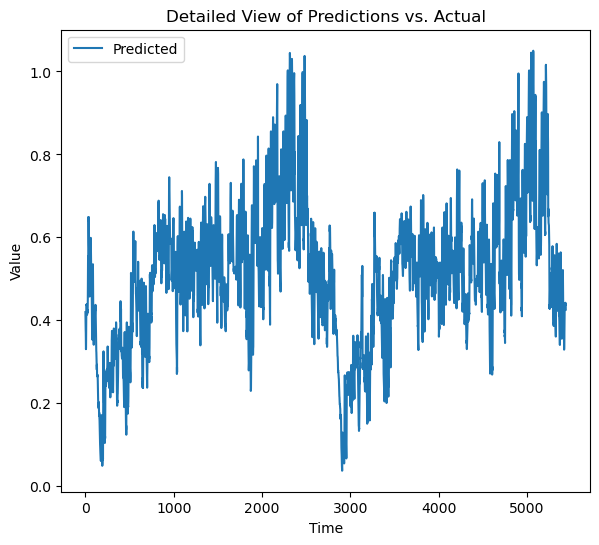

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
#plt.plot(y_test, label='Actual')
plt.plot(new_predictions, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()


plt.show()

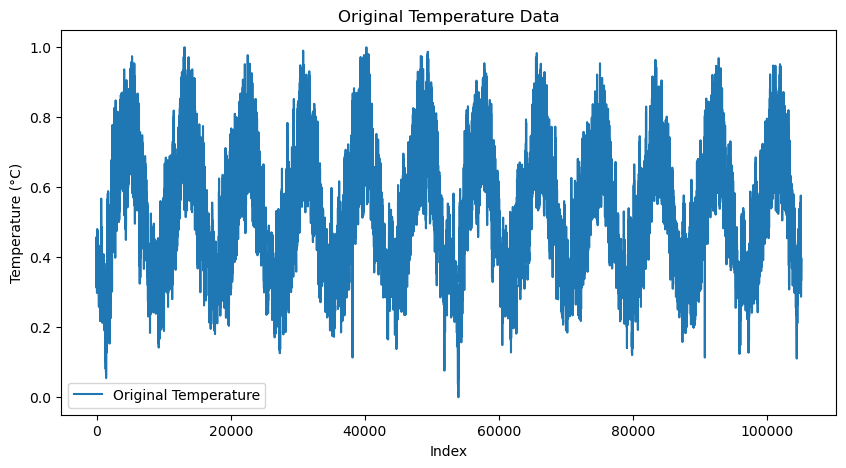

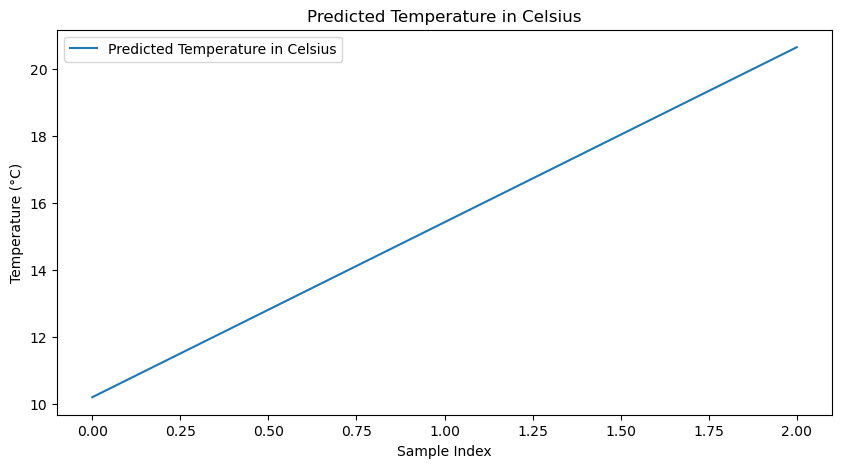

In [62]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler instance
temperature_scaler = MinMaxScaler()

temp_data = original_df['T2M'].copy()

# Fit the scaler to the temperature data
# Ensure temp_data is reshaped if it's a Series
temperature_scaler.fit(temp_data.values.reshape(-1, 1))

# Example of normalizing new temperature data
new_temp = np.array([23, 24, 22])  # Example new temperature data
new_temp_normalized = temperature_scaler.transform(new_temp.reshape(-1, 1))

# Example of inverse transforming predicted temperature data
predicted_temp_normalized = np.array([0.5, 0.6, 0.7])  # Example normalized predictions
predicted_temp_celsius = temperature_scaler.inverse_transform(predicted_temp_normalized.reshape(-1, 1))

import matplotlib.pyplot as plt

# Plotting the original temperature data
plt.figure(figsize=(10, 5))
plt.plot(df['T2M'], label='Original Temperature')
plt.title('Original Temperature Data')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting the inverse scaled predicted temperature
plt.figure(figsize=(10, 5))
plt.plot(predicted_temp_celsius, label='Predicted Temperature in Celsius')
plt.title('Predicted Temperature in Celsius')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()




In [58]:
# Assuming `temp_index` is the index of the temperature in the original dataset
temp_index = 4
temp_min = scaler.min_[temp_index]
temp_scale = scaler.scale_[temp_index]

# Manually inverse transform the temperature
temperature_in_celsius = new_predictions * temp_scale + temp_min

from sklearn.preprocessing import MinMaxScaler

# Suppose 'temp_data' is your temperature column from the training dataset
# Copying just the 'T2M' column into a new DataFrame
temp_data = df[['T2M']].copy()
temp_scaler = MinMaxScaler()
temp_scaler.fit(temp_data.reshape(-1, 1))  # Reshape if 'temp_data' is a 1D array

# Use this scaler to inverse transform your predictions
temperature_in_celsius = temp_scaler.inverse_transform(new_predictions)

# Assuming 'temperature_in_celsius' are your normalized temperature predictions
temperature_in_celsius = temperature_scaler.inverse_transform(new_predictions.reshape(-1, 1))

# Optionally reshape back if needed
temperature_in_celsius = temperature_in_celsius.reshape(-1)

plt.figure(figsize=(10, 5))
plt.plot(temperature_in_celsius, label='Temperature in Celsius')
plt.title('Predicted Temperature')
plt.xlabel('Samples')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


AttributeError: 'DataFrame' object has no attribute 'reshape'

In [46]:
# Assuming 'df' contains all your data and 'T2M' is the feature you are interested in
# scaler.fit(ddf[['T2M']])  # Fit the scaler to the 'T2M' data
# Fetch the last 'sequence_length' points for 'T2M'
latest_points = ddf[-sequence_length:][['T2M']]
latest_scaled = scaler.transform(latest_points)  # Scale the data

# Reshape for the model input, ensuring the shape matches the training input
latest_scaled = latest_scaled.reshape(1, sequence_length, 1, 1, 1)

# Predict using the model
today_prediction_scaled = model.predict(latest_scaled)
today_prediction = scaler.inverse_transform(today_prediction_scaled)  # Inverse scaling

print("Predicted T2M for today:", today_prediction.flatten()[0])



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- GL
- P0
- RH2M
- RR
- RR_lag1
- ...


In [17]:
# Continue with your scaling and data preparation
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['time']))  # Exclude 'time' or any non-numeric columns before scaling
df = pd.DataFrame(df_scaled, columns=[col for col in df.columns if col != 'time'])  # Re-create DataFrame without 'time'

# Re-attach the 'time' column if necessary for splits or future plotting
df['time'] = plotting_df['time']

# Create training and testing sets
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

train_df_time = train_df.drop(columns=['time'])
test_df_time = test_df.drop(columns=['time'])

In [9]:
def create_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data.iloc[i:(i + sequence_length)].values)
        y.append(input_data.iloc[i + sequence_length]['RR'])
    return np.array(X), np.array(y)

sequence_length = 24
X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)

# Reshape data for ConvLSTM
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_test.shape[2]))


In [10]:
# Model creation
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', input_shape=(sequence_length, 1, 1, X_train.shape[-1]), return_sequences=True),
    ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

2024-04-23 14:12:49.643427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 14:12:49.645987: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 24, 1, 1, 64)   │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 1, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,877 (140.14 KB)

 Trainable params: 35,877 (140.14 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define the checkpoint path and filename
checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Set to False if you want to save the entire model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # The lower the val_loss, the better
    save_best_only=True,  # Only save a model if `val_loss` has improved
    verbose=1  # Log message when saving the model
)

In [13]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5, 
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [13]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Mean Squared Error: 0.00010144797809832371
Root Mean Squared Error: 0.010072138705276238
Mean Absolute Error: 0.0019713988376412533


In [15]:
# Ensure that the indices match for test_time and test_df
test_df['time'] = test_time.reset_index(drop=True)

# Now let's handle adding predictions safely
# It's crucial to reset indices if there were any row filtering or dropping
test_df = test_df.reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred, columns=['predictions'])

# If y_pred_df has a different length, let's find out why
print("Length of test_df:", len(test_df))
print("Length of y_pred:", len(y_pred_df))

# Assuming they are now the same, or you've handled discrepancies
test_df['predictions'] = y_pred_df['predictions']


Length of test_df: 21022
Length of y_pred: 20998


/tmp/ipykernel_78697/3869611161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['time'] = test_time.reset_index(drop=True)


In [16]:

test_df['time'] = test_time
test_df['predictions'] = y_pred  # Assuming y_pred are your model's predictions

# Sort by time if necessary (it depends on whether the order was preserved)
test_df.sort_values('time', inplace=True)

# Plotting actual vs predicted values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(test_df['time'], test_df['actual'], label='Actual Values')  # Ensure there's an 'actual' column or adjust accordingly
plt.plot(test_df['time'], test_df['predictions'], label='Predicted Values')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

ValueError: Length of values (20998) does not match length of index (21022)

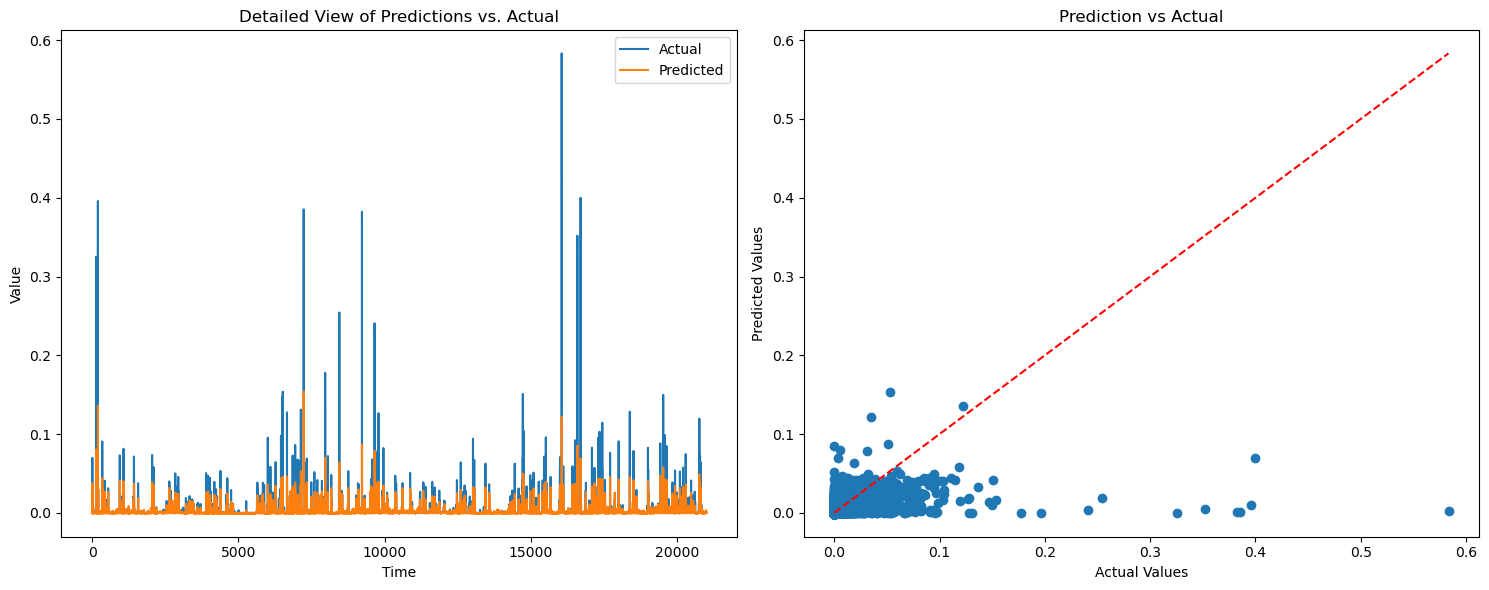

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line

plt.tight_layout()
plt.show()


In [ ]:
# Example of merging predictions back with the original time for plotting
results_df = test_df[['time']].copy()  # Starting with time from the test set
results_df['actual'] = y_test  # Assuming y_test is accessible and aligned
results_df['predicted'] = y_pred  # Assuming y_pred is obtained from the model

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(results_df['time'], results_df['actual'], label='Actual', linewidth=2)
plt.plot(results_df['time'], results_df['predicted'], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted over Time')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()


In [85]:
# Save the entire model to a HDF5 file
model_name = "final_model{date:%Y%m%dT%H%M%S}.h5".format(date=datetime.now())
model.save(model_name)

# Load the model back
from tensorflow.keras.models import load_model
loaded_model = load_model(model_name)

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}